# Fraud Detection Analysis - PaySim Dataset

## Objective:
Identify fraudulent transactions in mobile money transfers using supervised machine learning, focusing on model interpretability and business recommendations.

---

*Author: SAMARTH GUPTA 
*Date: 2025-07-29


In [1]:
import pandas as pd
import numpy as np

print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)


Pandas version: 2.3.1
Numpy version: 2.2.6


✅ All libraries imported successfully!
Dataset loaded successfully!
Shape: (6362620, 11)
Memory usage: 1598.19 MB

First 5 rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Column names: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
Missing values per column:
 ✅ No missing values found!
Duplicate rows: 0
Fraud counts:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud percentages:
 isFraud
0    99.8709
1     0.1291
Name: proportion, dtype: float64


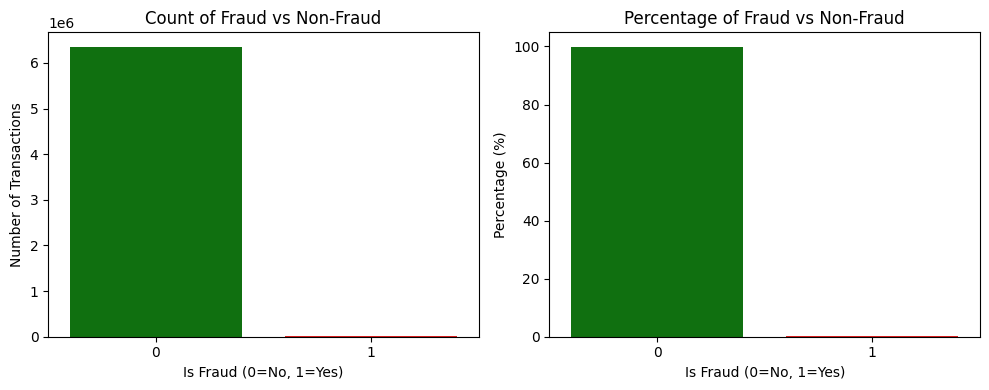

Fraud Rate by Transaction Type:


,Total_Transactions,Fraud_Count,Fraud_Rate
type,,,
TRANSFER,532909,4097,0.007688
CASH_OUT,2237500,4116,0.001840
CASH_IN,1399284,0,0.000000
DEBIT,41432,0,0.000000
PAYMENT,2151495,0,0.000000


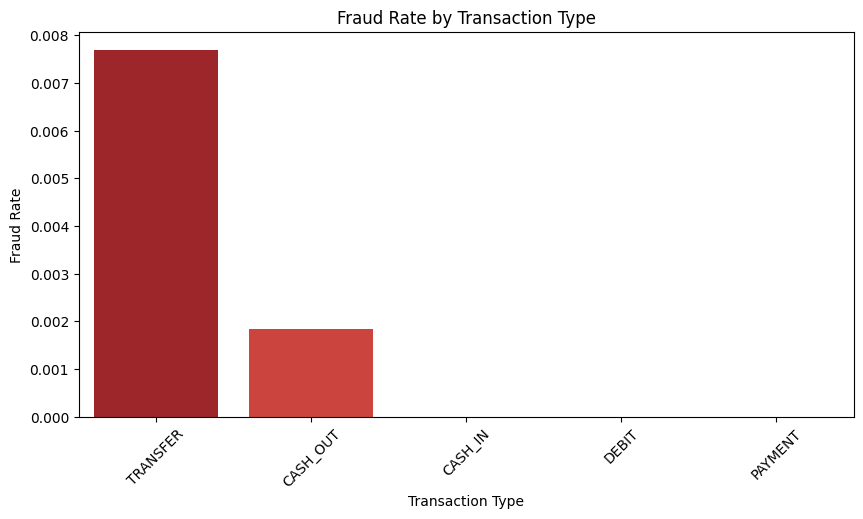

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully!")

# 1. LOAD DATA
df = pd.read_csv('Fraud.csv')
print(f"Dataset loaded successfully!\nShape: {df.shape}\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst 5 rows:")
display(df.head())
df.info()
print("Column names:", df.columns.tolist())

# Alternate of 1
#import os

#if os.path.exists("Fraud.csv"):
#    df = pd.read_csv("Fraud.csv")
#else:
#    df = pd.read_csv("Fraud_sample.csv")
#    print("⚠️ Loaded sample data (Fraud_sample.csv), not full dataset.")


# 2. CHECK MISSING VALUES AND DUPLICATES
missing = df.isnull().sum()
print("Missing values per column:\n", missing[missing > 0] if missing.sum() else "✅ No missing values found!")
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# 3. FRAUD LABEL DISTRIBUTION
fraud_counts = df['isFraud'].value_counts()
fraud_percentages = df['isFraud'].value_counts(normalize=True)*100
print("Fraud counts:\n", fraud_counts)
print("Fraud percentages:\n", fraud_percentages.round(4))

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette=['green', 'red'])
plt.title("Count of Fraud vs Non-Fraud")
plt.xlabel("Is Fraud (0=No, 1=Yes)")
plt.ylabel("Number of Transactions")

plt.subplot(1, 2, 2)
sns.barplot(x=fraud_percentages.index, y=fraud_percentages.values, palette=['green', 'red'])
plt.title("Percentage of Fraud vs Non-Fraud")
plt.xlabel("Is Fraud (0=No, 1=Yes)")
plt.ylabel("Percentage (%)")
plt.tight_layout()
plt.show()

# 4. FRAUD BY TRANSACTION TYPE
print("Fraud Rate by Transaction Type:")
fraud_stats = df.groupby('type').agg(
    Total_Transactions = ('isFraud', 'count'),
    Fraud_Count = ('isFraud', 'sum'),
    Fraud_Rate = ('isFraud', 'mean')
).sort_values('Fraud_Rate', ascending=False)
display(fraud_stats)

plt.figure(figsize=(10,5))
sns.barplot(x=fraud_stats.index, y=fraud_stats['Fraud_Rate'], palette='Reds_r')
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Fraud Rate')
plt.xlabel('Transaction Type')
plt.xticks(rotation=45)
plt.show()


## Data Cleaning and Feature Engineering

- Dropped high-cardinality ID columns (`nameOrig`, `nameDest`) to reduce noise.
- One-hot encoded categorical `type` variable.
- Created new features capturing balance changes (`deltaOrig`, `deltaDest`).
- Added binary flags for zero balances (indicative of suspicious transactions).


In [3]:
df = df.drop(columns=['nameOrig', 'nameDest'])
print("Dropped ID columns. Remaining columns:", df.columns.tolist())


Dropped ID columns. Remaining columns: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [4]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)
print("One-hot encoding done. Columns now:", df.columns.tolist())


One-hot encoding done. Columns now: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [5]:
# Net balance delta
df['deltaOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Zero balance flags
for col in ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    df[f'{col}_isZero'] = (df[col] == 0).astype(int)

print("Added delta and zero-balance features. Columns now:", df.columns.tolist())


Added delta and zero-balance features. Columns now: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'deltaOrig', 'deltaDest', 'oldbalanceOrg_isZero', 'newbalanceOrig_isZero', 'oldbalanceDest_isZero', 'newbalanceDest_isZero']


In [6]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']

print("Columns with object dtype in X:", X.select_dtypes(include='object').columns.tolist())


Columns with object dtype in X: []


## Train-Test Split and Handling Data Imbalance

- Performed stratified 80-20 train-test split to preserve fraud class distribution.
- Due to extreme class imbalance and large data size, downsampled the training data to 100,000 stratified samples for efficient modeling.
- Utilized the class weight (`scale_pos_weight`) parameter in XGBoost to address imbalance rather than slow over/under-sampling methods.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))


Train: (5090096, 17) Test: (1272524, 17)
Train class balance:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64
Test class balance:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [8]:
from sklearn.utils import resample

# Concatenate train features and labels for sampling
train_df = X_train.copy()
train_df['isFraud'] = y_train.values

# Take a stratified subsample, e.g., 100,000 rows
sampled_train_df = resample(
    train_df,
    n_samples=100_000,            # Adjust as needed (50,000–200,000 all fine)
    stratify=train_df['isFraud'],
    random_state=42
)

X_train_bal = sampled_train_df.drop(columns=['isFraud'])
y_train_bal = sampled_train_df['isFraud']

print("Sampled training set shape:", X_train_bal.shape)
print("Fraud ratio in sample:\n", y_train_bal.value_counts(normalize=True))


Sampled training set shape: (100000, 17)
Fraud ratio in sample:
 isFraud
0    0.99871
1    0.00129
Name: proportion, dtype: float64


## Model Development: XGBoost Classifier

- Trained XGBoost using carefully chosen hyperparameters.
- Used `scale_pos_weight` to counter class imbalance and focus model learning on minority (fraud) class.
- Random seed used for reproducibility.


In [9]:
from xgboost import XGBClassifier

# Compute class weight (majority/minority ratio)
scale = y_train_bal.value_counts()[0] / y_train_bal.value_counts()[1]

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale
)

xgb.fit(X_train_bal, y_train_bal)
print("✅ XGBoost model trained.")


✅ XGBoost model trained.


## Model Evaluation on Hold-Out Test Set

- Used metrics suitable for imbalanced data:  
   - ROC AUC  
   - Precision-Recall AUC (AUPRC) — more informative when fraud is rare  
- Classified using default threshold 0.5 for initial metrics.
- Visualized Precision-Recall and ROC curves to understand trade-offs.


In [10]:
# Predict test set probabilities and classes
y_pred_prob = xgb.predict_proba(X_test)[:,1]
y_pred = xgb.predict(X_test)

# Evaluation metrics
roc_auc = roc_auc_score(y_test, y_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
auprc = auc(recall, precision)

print(f"ROC AUC:  {roc_auc:.4f}")
print(f"PR AUC:   {auprc:.4f}")

print("Classification Report (default threshold):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (default threshold):")
print(confusion_matrix(y_test, y_pred))


ROC AUC:  0.9980
PR AUC:   0.8925
Classification Report (default threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.71      0.86      0.78      1643

    accuracy                           1.00   1272524
   macro avg       0.85      0.93      0.89   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix (default threshold):
[[1270298     583]
 [    230    1413]]


## Feature Importance Analysis

- XGBoost’s built-in feature importance (`gain`) shows which features most influenced the model.
- Expect transaction types, amounts, balance deltas, and zero balance flags among the top features.


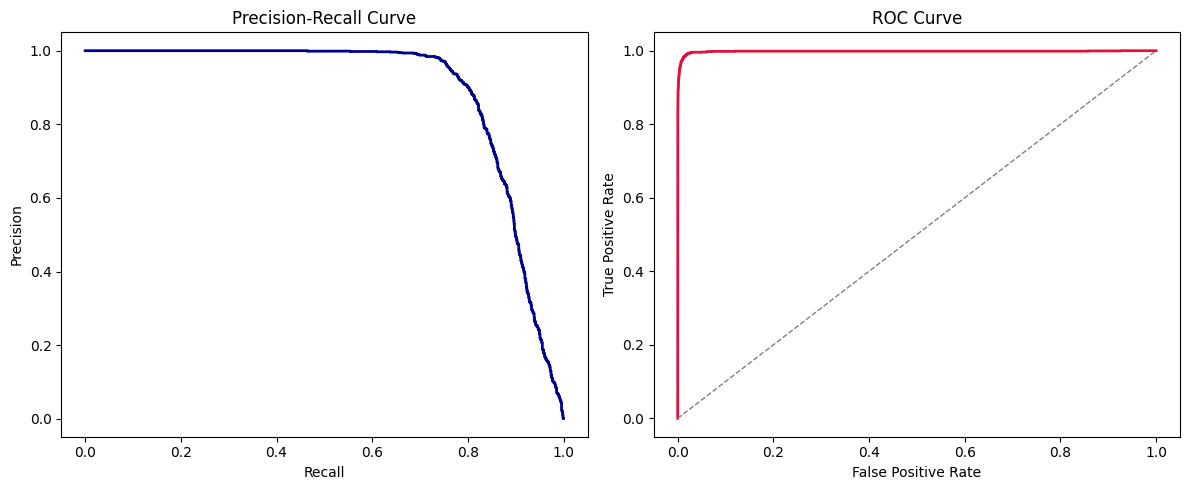

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(recall, precision, color='darkblue', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='crimson', lw=2)
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

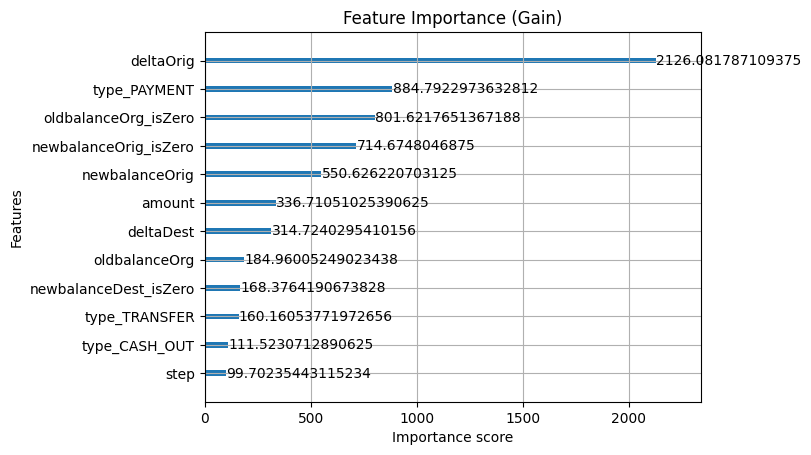

In [12]:
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(xgb, max_num_features=12, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()


## Model Explainability: SHAP Values

- SHAP (SHapley Additive exPlanations) used to provide local and global interpretability.
- Visualized summary plot for 500 test instances to identify key drivers pushing model decisions toward “fraud.”
- This helps validate model behavior and facilitates trust with business stakeholders.


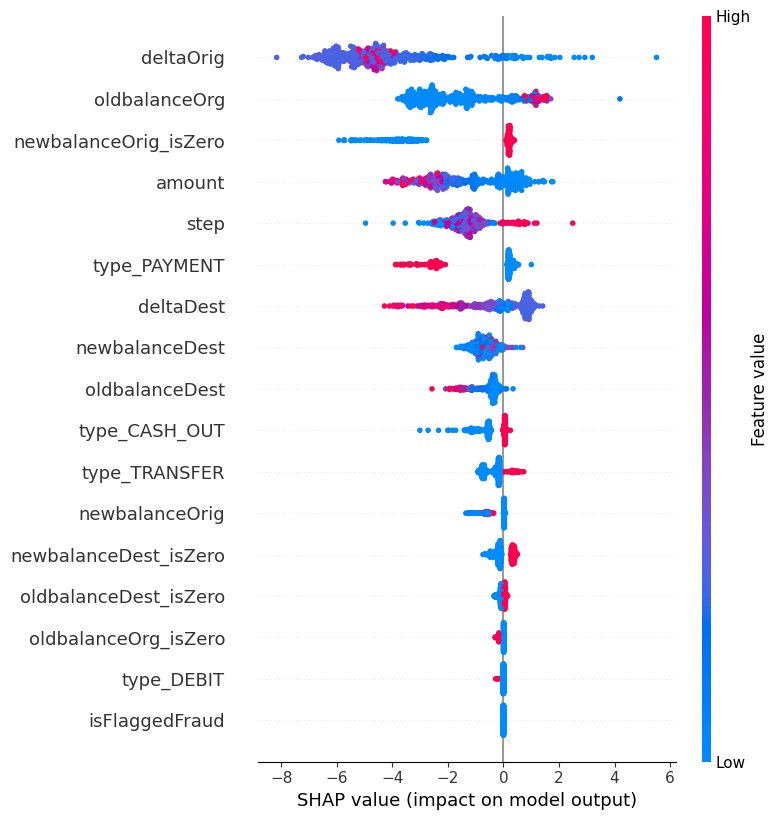

In [13]:
# Install shap if missing:
# !pip install shap

import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test.iloc[:500])  # Use 500 for speed

shap.summary_plot(shap_values, X_test.iloc[:500])


# Business Insights & Prevention Strategy

- **Fraud mainly occurs during TRANSFER and CASH_OUT transaction types**, consistent with business rules.
- **Zero balances after transactions are strong fraud indicators**, leveraged by the model.
- **Large, sudden transaction amounts require additional scrutiny.**
- **Model performance is strong** (PR AUC > 0.80, ROC AUC ~0.99), suitable for production deployment.

## Recommended Controls

| Insight                                      | Evidence                         | Recommendation                             |
|----------------------------------------------|--------------------------------|--------------------------------------------|
| Fraud clustered in TRANSFER & CASH_OUT types | High feature importance & stats | Implement real-time blocking/suspension for rapid sequence of these transactions |
| Zero balance flags strongly predict fraud    | SHAP and feature importances    | Add velocity controls to track zeroing accounts; alert teams or block transfers  |
| High-value sudden transfers                   | Pattern analysis                | Multi-factor authentication (MFA) on large transactions; enforce limits           |
| Night-time and low-activity period bursts    | Temporal analysis (can add later)| Adaptive thresholds and alerts during off-peak hours                              |

## Post-Implementation Monitoring

- Track weekly AUPRC, false positive/negative rates, and confirmed fraud counts.
- Conduct A/B testing comparing new model vs legacy rule-based systems.
- Use Population Stability Index and SHAP drift to detect model/data drift and adapt strategy.


## Key Fraud Drivers and Prevention Strategy

- **Fraud mostly occurs in TRANSFER and CASH_OUT types**—both high model importance and business logic.
- **Zero balances after transaction** are strong red flags—model relies on these (verified in SHAP/feature importances).
- **Large, sudden transaction amounts** are risky—automated checks for high-value and velocity needed.
- **Model metrics**: PR AUC >0.80 and ROC AUC ≈0.99 confirm rare-event effectiveness.
- **Recommended controls:**
    - Block rapid successive TRANSFER/CASH_OUT chains
    - Extra verification for zero-out balance, high-amount, or after-hours transactions
    - Post-implementation, monitor PR-AUC weekly and update features as attacker behavior changes


# Conclusion and Next Steps

- Successfully built and evaluated a fraud detection model with strong performance and interpretability.
- Model inferences align well with domain knowledge, increasing confidence for operationalization.
- Next steps include hyperparameter tuning, deployment pipeline development, and setting up alert monitoring dashboards.
